In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax

In [12]:
from scipy import integrate

# integrand for potential component of Hamiltonian matrix element for gaussian basis functions
def integrand(x,V,xi,xj,alpha):
    return np.exp(-alpha*(x-xi)**2)*V(x)*np.exp(-alpha*(x-xj)**2)

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def basis_V(N,V):
    #N = 3                       # half the number of basis functions
    K = 2*N+1                    # total number of basis functions
    dx = 0.4                     # spacing between basis functions
    alpha = 1.0                  # 1/spread of basis functions
    xvals = np.arange(-3,10,0.1)  # x domain for psi
    xmin = -N*dx                 # minimum x value for basis functions
    xIntegrand = np.arange(xmin-1.0/alpha*10,abs(xmin)+1.0/alpha*10,0.01)
    S = np.zeros((K,K),dtype=float)   # basis function overlap matrix
    H = np.zeros((K,K),dtype=float)   # Hamiltonian matrix, Hij = <Si|H|Sj>

    # populate the basis function, S, and Hamiltonian, H, matrices
    for i in range(K):
        xi = xmin + (i-1)*dx
        for j in range(K):
            xj = xmin + (j-1)*dx
            # basis function value:
            # Ostlund and Szabo page 47
            S[i,j] = np.sqrt(0.5*np.pi/alpha)*np.exp(-0.5*alpha*(xi-xj)**2)
            # Hamiltonian value (standard Harmonic Oscillator matrix element - applied to basis functions)
            H[i,j] = 0.5*S[i,j]*(alpha - (alpha**2)*(xi-xj)**2) # Kinetic energy
#            H[i,j] += integrate.quad(integrand,-np.inf,np.inf,args=(V,xi,xj,alpha))[0] # potential energy using numeric integration
            H[i,j] += integrate.simps(integrand(xIntegrand,V,xi,xj,alpha),xIntegrand)
    # finalize the S^-1*H*S matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these so largest eigenvalue is first
    idx = H_eig_val.argsort()   
    H_eig_val = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]

    nx = xvals.size
    psi = np.zeros((nx,K),dtype=float)
    # generate psis from coefficients
    for A in range(K):
        count = K-A-1
        for i in range(K):
            xi = xmin + (i-1)*dx
            psi[:,A] = psi[:,A] + H_eig_vec[i,A]*np.exp(-alpha*(xvals-xi)**2)
    
        # normalize the wavefunctions
        psi2 = psi[:,A]**2
        norm = integrate.simps(psi2,xvals)
        psi[:,A] /= np.sqrt(norm)

    return psi, H_eig_val

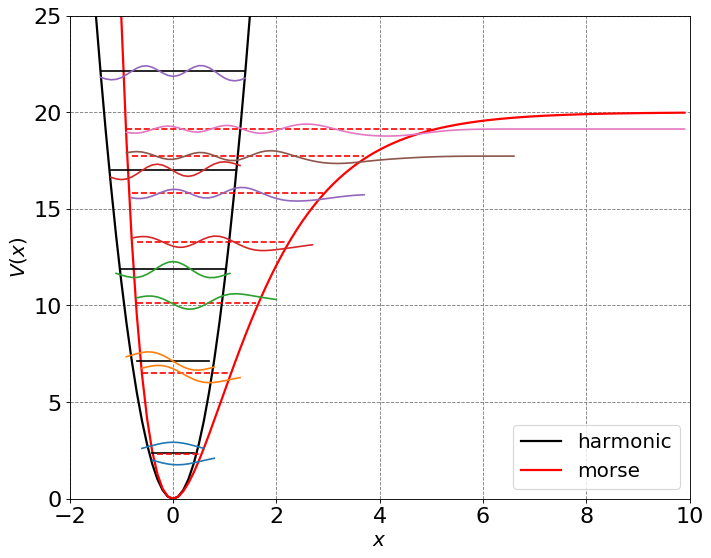

In [11]:
De = 20.0
beta = 0.75
xvals = np.arange(-3,10,0.1)

def anharmonic(x):
    return De*beta**2*x**2 - De*beta**3*(x)**3 + 7./12.*De*beta**4*x**4

def harmonic(x):
    return De*beta**2*x**2

def morse(x):
    return De*(1-np.exp(-beta*x))**2

#fig, ax = plt.subplots(figsize=(12,8))
# initialize a figure
ax = define_figure(xlabel="x",ylabel="V(x)")
U_h = harmonic(xvals)
U_ah = anharmonic(xvals)
U_morse = morse(xvals)
ax.plot(xvals, U_h, 'k',lw=2,label="harmonic")
#ax.plot(xvals, U_ah, 'b',lw=2,label="anharmonic")
ax.plot(xvals, morse(xvals), 'r',lw=2,label="morse")
psi_h, E_h = basis_V(10,harmonic)
#psi_ah, E_ah = basis_V(10,anharmonic)
psi_morse, E_morse = basis_V(10,morse)
for n in range(10):
    # plot the energy level
    mask = np.where(E_h[n] > U_h)  
    ax.plot(xvals[mask], E_h[n] * np.ones(np.shape(xvals))[mask], 'k')
    # plot the wavefunction
    Y = psi_h[:,n]/2.0+E_h[n]
    mask = np.where(Y > U_h-2.0)
    ax.plot(xvals[mask], Y[mask].real)
#for n in range(10):
#    Y = psi_ah[:,n]/2.0+E_ah[n]
#    mask = np.where(E_ah[n] > U_ah)  
#    ax.plot(xvals[mask], E_h[n] * np.ones(np.shape(xvals))[mask], 'b--')
#
#    mask = np.where(Y > U_ah-2.0)
#    ax.plot(xvals[mask], Y[mask].real)  
for n in range(10):
    if (E_morse[n] <= De):
        # plot the energy level
        mask = np.where(E_morse[n] > U_morse)  
        ax.plot(xvals[mask], E_morse[n] * np.ones(np.shape(xvals))[mask], 'r--')
        # plot the wavefunction
        Y = psi_morse[:,n]/2.0+E_morse[n]
        mask = np.where(Y > U_morse-2.0)
        ax.plot(xvals[mask], Y[mask].real)     
ax.set_xlim(-2, 10)
ax.set_ylim(0, 25)
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$V(x)$', fontsize=18)
ax.legend(loc=4,fontsize=18)